# C02. Players

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Utilities.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"

### Goals:
- Compare my FP projections to actual FP scored
    - Main breakdowns
        - Batters
            - Overall
            - Lefty*
            - Righty*
            - Unimputed
            - Imputed
            - Unsubbed
        - Pitchers (SP only)
            - Overall
            - Lefty*
            - Righty*
            - Unimputed
            - Imputed
    - By projection quantile
        - Batters
        - Pitchers (SP only)
    - By park
        - Batters
        - Pitchers (SP only)
    - By year
        - Batters
        - Pitchers (SP only)

- Compare my scoring component projections to actual scoring component scoring (projected singles vs. actual singles, etc...) (mean)
    - Batters
    - Pitchers (SP only)
    
- Compare my FP projections to other FP projections (mean, MSE)
    - Batters
    - Pitchers (SP only)

### Dates

In [2]:
start_date = "20240318"
# end_date = yesterdaysdate
end_date = "20240930"

### Games

Games played

In [3]:
# game_df = read_and_save_games(team_map, generate=True)
# game_df = game_df[(game_df['date'] >= start_date) & (game_df['date'] <= end_date)].reset_index(drop=True)
game_df = create_games(start_date, end_date, team_map)

Dates and games with my projections

In [4]:
date_list = list(game_df['date'].unique())
date_folders = [f"Matchups {date}" for date in date_list]

game_list = list(game_df['game_id'].unique())
player_folders = [f"Players {game}" for game in game_list]

### Functions

Extract date, teams, and gamePk from folder names

In [5]:
def extract_info_from_folder(date_folder, matchup_folder):
    # Extract date from date folder
    date = date_folder.split(' ')[1]
    
    # Extract teams and gamePK from matchup folder
    parts = matchup_folder.split(' ')
    away_team, home_team = parts[0].split('@')
    gamePk = parts[1]
    
    return date, away_team, home_team, gamePk

Average player stats for a given position group

In [6]:
def game_averages(date_folder, matchup_folder, position='pitchers'):
    date, away_team, home_team, gamePk = extract_info_from_folder(date_folder, matchup_folder)
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Get a list of all CSV files in the matchup folder
    csv_files = [file for file in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder, matchup_folder)) if file.startswith(position) and file.endswith('.csv')]
    
    # Iterate over each CSV file
    for csv_file in csv_files:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder, matchup_folder, csv_file))
        
        # Append date, away_team, home_team, and gamePk columns
        df['date'] = date
        df['away_team'] = away_team
        df['home_team'] = home_team
        df['gamePk'] = gamePk
        
        # Append the DataFrame to the list
        dfs.append(df)
    
    # Concatenate all DataFrames in the list
    combined_df = pd.concat(dfs)
    
    # Select numeric columns
    numeric_cols = combined_df.select_dtypes(include='number')
    
    # Group by fullName and calculate the mean for numeric columns
    averaged_numeric_cols = numeric_cols.groupby(combined_df['fullName'], sort=False).mean()
    
    # Select team and additional columns
    additional_cols = combined_df[['fullName', 'team', 'date', 'away_team', 'home_team', 'gamePk']].drop_duplicates('fullName').set_index('fullName')
    
    # Concatenate numeric and additional columns
    averaged_df = pd.concat([additional_cols, averaged_numeric_cols], axis=1).reset_index()

    averaged_df['team_abbrev'] = np.where(averaged_df['team'] == "away", averaged_df['away_team'], averaged_df['home_team'])

    averaged_df['starter'] = (~averaged_df['team'].duplicated()).astype(int)

    return averaged_df

### Player Sim Files

Calculate averages for player stats in simulations by game

##### Batters

Calculate averages

In [7]:
%%time
position = 'batters'

# Parallelize the loop using joblib and directly return df_list
batter_df_list = Parallel(n_jobs=-1)(
    delayed(game_averages)(date_folder, matchup_folder, position) 
    for date_folder in date_folders 
    for matchup_folder in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder)))

CPU times: total: 15.1 s
Wall time: 2min 23s


Write to CSV

In [8]:
for df in batter_df_list:
    gamePk = df['gamePk'][0]
    away_df = df.query('team == "away"')
    home_df = df.query('team == "home"')
    
    # Create folder
    os.makedirs(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}"), exist_ok=True)

    # Write to csv
    away_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away batters projections {gamePk}.csv"), index=False)
    home_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home batters projections {gamePk}.csv"), index=False)

##### Pitchers

Calculate averages

In [9]:
%%time
position = 'pitchers'

# Parallelize the loop using joblib and directly return df_list
pitcher_df_list = Parallel(n_jobs=-1)(
    delayed(game_averages)(date_folder, matchup_folder, position) 
    for date_folder in date_folders 
    for matchup_folder in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder)))

CPU times: total: 15.2 s
Wall time: 2min 35s


Write to CSV

In [10]:
for df in pitcher_df_list:
    gamePk = df['gamePk'][0]
    away_df = df.query('team == "away"')
    home_df = df.query('team == "home"')
    
    # Create folder
    os.makedirs(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}"), exist_ok=True)

    # Write to csv
    away_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away pitchers projections {gamePk}.csv"), index=False)
    home_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home pitchers projections {gamePk}.csv"), index=False)

### Player Scoring

Add players' actual scoring onto simulated projections

##### Batters

In [11]:
# Define a function to process each folder
def process_batters(folder):
    # Extract gamePk
    gamePk = folder.split(" ")[1]

    ### Batters
    ## Away
    # Read in projections
    away_batter_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away batters projections {gamePk}.csv"))
    # Read in results
    away_batter_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"away batters {gamePk}.csv"))

    # Merge
    away_batters_merged = away_batter_projected_results_df[['fullName', 'id', 'imp_b_l', 'imp_b_r', 'PA', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'SB', 'R', 'RBI', 'FP', 'gamePk']].merge(away_batter_actual_results_df, left_on=['id', 'gamePk'], right_on=['personId', 'gamePk'], how='outer')

    ## Home
    # Read in projections
    home_batter_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home batters projections {gamePk}.csv"))
    # Read in results
    home_batter_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"home batters {gamePk}.csv"))

    # Merge
    home_batters_merged = home_batter_projected_results_df[['fullName', 'id', 'imp_b_l', 'imp_b_r', 'PA', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'SB', 'R', 'RBI', 'FP', 'gamePk']].merge(home_batter_actual_results_df, left_on=['id', 'gamePk'], right_on=['personId', 'gamePk'], how='outer')

    # Append them together
    batters_merged = pd.concat([away_batters_merged, home_batters_merged], axis=0)

    
    return batters_merged

In [12]:
def process_batters2(folder):
    try:
        batters_merged = process_batters(folder)    
        return batters_merged   
    except:
        pass 

In [13]:
%%time
# Run the loop in parallel
batters_merged_list = Parallel(n_jobs=-1)(delayed(process_batters2)(folder) for folder in player_folders)
batters_merged_df = pd.concat(batters_merged_list, axis=0)

CPU times: total: 6.28 s
Wall time: 11.1 s


##### Pitchers

In [14]:
def process_pitchers(folder):
    # Extract gamePk
    gamePk = folder.split(" ")[1]
    
    ### Pitchers
    ## Away
    # Read in projections
    away_pitcher_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away pitchers projections {gamePk}.csv"))
    away_pitcher_projected_results_df['team'] = "away"
    # Read in results
    away_pitcher_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"away pitchers {gamePk}.csv"))

    # Merge
    away_pitchers_merged = away_pitcher_projected_results_df[['fullName', 'id', 'imp_p_l', 'imp_p_r', 'OUT', 'PA', 'SO', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'H', 'R', 'ER', 'W', 'CG', 'CGSO', 'NH', 'FP', 'team', 'gamePk']].merge(away_pitcher_actual_results_df, left_on=['id', 'gamePk', 'team'], right_on=['personId', 'gamePk', 'team'], how='outer')
    
    ## Home
    # Read in projections
    home_pitcher_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home pitchers projections {gamePk}.csv"))
    home_pitcher_projected_results_df['team'] = "home"
    # Read in results
    home_pitcher_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"home pitchers {gamePk}.csv"))

    # Merge
    home_pitchers_merged = home_pitcher_projected_results_df[['fullName', 'id', 'imp_p_l', 'imp_p_r', 'OUT', 'PA', 'SO', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'H', 'R', 'ER', 'W', 'CG', 'CGSO', 'NH', 'FP', 'team', 'gamePk']].merge(home_pitcher_actual_results_df, left_on=['id', 'gamePk', 'team'], right_on=['personId', 'gamePk', 'team'], how='outer')

    # Append them together
    pitchers_merged = pd.concat([away_pitchers_merged, home_pitchers_merged], axis=0)

    
    return pitchers_merged

In [15]:
def process_pitchers2(folder):
    try:
        pitchers_merged = process_pitchers(folder)    
        return pitchers_merged   
    except:
        pass 

In [16]:
%%time
# Run the loop in parallel
pitchers_merged_list = Parallel(n_jobs=-1)(delayed(process_pitchers2)(folder) for folder in player_folders)
pitchers_merged_df = pd.concat(pitchers_merged_list, axis=0)

CPU times: total: 4.89 s
Wall time: 11.6 s


In [17]:
pitchers_merged_df.query('gamePk == 744795')

,fullName,id,imp_p_l,imp_p_r,OUT,PA,SO,HBP,BB,B1,B2,B3,HR,H,R,ER,W,CG,CGSO,NH,FP,team,gamePk,name,personId,starter,ip,pa,outs,h,r,er,bb,k,hr,hbp,w,l,cg,cgso,nh,fp,date,year,venue_id,teamabbrev
0,Michael Lorenzen,547179.0,0.0,0.0,16.500000,22.708333,5.187500,0.145833,2.000000,3.229167,0.791667,0.104167,0.479167,4.604167,2.375000,1.875000,0.395833,0.020833,0.0,0.0,16.585417,away,744795,Lorenzen,547179.0,1.0,2.1,9.0,7.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.05,20240925.0,2024.0,3309.0,KCR
1,Angel Zerpa,672582.0,0.0,0.0,1.583333,2.270833,0.354167,0.000000,0.187500,0.395833,0.125000,0.000000,0.020833,0.541667,0.187500,0.187500,0.000000,0.000000,0.0,0.0,1.083333,away,744795,Zerpa,672582.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.25,20240925.0,2024.0,3309.0,KCR
2,Carlos Hernandez,672578.0,0.0,0.0,1.729167,2.500000,0.583333,0.000000,0.270833,0.375000,0.083333,0.000000,0.104167,0.562500,0.270833,0.270833,0.041667,0.000000,0.0,0.0,1.588542,away,744795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Sam Long,669674.0,0.0,0.0,1.791667,2.604167,0.583333,0.000000,0.208333,0.312500,0.145833,0.041667,0.104167,0.604167,0.458333,0.375000,0.020833,0.000000,0.0,0.0,1.356250,away,744795,Long,669674.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.25,20240925.0,2024.0,3309.0,KCR
4,Daniel Lynch IV,663738.0,0.0,0.0,0.645833,0.833333,0.166667,0.020833,0.062500,0.083333,0.041667,0.000000,0.000000,0.125000,0.041667,0.020833,0.000000,0.000000,0.0,0.0,0.651042,away,744795,Lynch IV,663738.0,0.0,2.2,11.0,8.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12.20,20240925.0,2024.0,3309.0,KCR
5,Kris Bubic,663460.0,0.0,0.0,1.104167,1.625000,0.312500,0.041667,0.145833,0.229167,0.166667,0.000000,0.000000,0.395833,0.270833,0.270833,0.020833,0.000000,0.0,0.0,0.644792,away,744795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Lucas Erceg,668674.0,0.0,0.0,1.083333,1.645833,0.250000,0.000000,0.208333,0.291667,0.041667,0.020833,0.041667,0.395833,0.250000,0.187500,0.000000,0.000000,0.0,0.0,0.575000,away,744795,Erceg,668674.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.25,20240925.0,2024.0,3309.0,KCR
7,John Schreiber,670167.0,0.0,0.0,1.166667,1.541667,0.187500,0.041667,0.187500,0.083333,0.062500,0.000000,0.041667,0.187500,0.145833,0.145833,0.000000,0.000000,0.0,0.0,0.708333,away,744795,Schreiber,670167.0,0.0,1.0,5.0,3.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.05,20240925.0,2024.0,3309.0,KCR
0,DJ Herz,687792.0,0.0,0.0,15.583333,21.500000,5.500000,0.250000,1.416667,2.791667,0.979167,0.062500,0.770833,4.604167,2.104167,2.062500,0.229167,0.020833,0.0,0.0,15.768750,home,744795,Herz,687792.0,1.0,5.0,21.0,15.0,3.0,1.0,1.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.65,20240925.0,2024.0,3309.0,WSN
1,Eduardo Salazar,674285.0,0.0,0.0,1.437500,2.270833,0.333333,0.041667,0.229167,0.541667,0.020833,0.000000,0.083333,0.645833,0.416667,0.416667,0.041667,0.000000,0.0,0.0,0.528125,home,744795,Salazar,674285.0,0.0,0.0,3.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.80,20240925.0,2024.0,3309.0,WSN


### 1. Player Stat Evaluations

Compare simulated projections to player stats

In [18]:
player_stat_path = os.path.join(baseball_path, "C02. Players", "1. Player Stat Evaluations", f"{todaysdate} Player Stat Evaluations.xlsx")

##### Batters

Create New Variables

In [19]:
# Actual singles
batters_merged_df['singles'] = batters_merged_df['h'] - batters_merged_df['doubles'] - batters_merged_df['triples'] - batters_merged_df['hr']
# Actual PA
batters_merged_df['pa'] = batters_merged_df[['ab', 'bb', 'hbp']].sum(axis=1)
# Projected hits
batters_merged_df['H'] = batters_merged_df[['B1', 'B2', 'B3', 'HR']].sum(axis=1)
# Reached
batters_merged_df['ON'] = batters_merged_df[['H', 'BB', 'HBP']].sum(axis=1)
batters_merged_df['on'] = batters_merged_df[['h', 'bb', 'hbp']].sum(axis=1)

In [20]:
# Identify number of batters that batted in a given spot in the order (we may only want those who were never subbed out or are subs)
batters_merged_df['battingSpot'] = batters_merged_df['battingOrder'] // 100
# Instance of batter in that spot
# Example:
# Three batters batted 4
# All three would have battingSpot = 4
# battingSpotInstance for starter would be 1, the first sub would be 2, second sub would be 3
batters_merged_df['battingSpotInstance'] = batters_merged_df.groupby(['gamePk', 'team', 'battingSpot'])['battingSpot'].transform('count')

##### Starters

In [21]:
all_batters = batters_merged_df.query('battingSpotInstance == 1')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = all_batters.T.iloc[::2].reset_index()
actual = all_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
all_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
all_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Write to Excel
all_batters.to_excel(player_stat_path, sheet_name='AllBatters', index=False)

##### Starters - Unimputed

In [22]:
unimputed_batters = batters_merged_df.query('battingSpotInstance == 1').query('imp_b_l == 0 & imp_b_r == 0')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = unimputed_batters.T.iloc[::2].reset_index()
actual = unimputed_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
unimputed_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
unimputed_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Set Projected Share
unimputed_batters['Projected Share'] = 0.0
unimputed_batters.loc[unimputed_batters['Projected'] == 'PA', 'Projected Share'] = 1
unimputed_batters.loc[unimputed_batters['Projected'] == 'ON', 'Projected Share'] = (
    unimputed_batters.loc[unimputed_batters['Projected'] == 'ON', 'Projected Mean'].values[0] /
    unimputed_batters.loc[unimputed_batters['Projected'] == 'PA', 'Projected Mean'].values[0]
)
unimputed_batters.loc[~unimputed_batters['Projected'].isin(['PA', 'ON']), 'Projected Share'] = (
    unimputed_batters.loc[~unimputed_batters['Projected'].isin(['PA', 'ON']), 'Projected Mean'] /
    unimputed_batters.loc[unimputed_batters['Projected'] == 'ON', 'Projected Mean'].values[0]
)

# Set Actual Share
unimputed_batters['Actual Share'] = 0.0
unimputed_batters.loc[unimputed_batters['Actual'] == 'pa', 'Actual Share'] = 1
unimputed_batters.loc[unimputed_batters['Actual'] == 'on', 'Actual Share'] = (
    unimputed_batters.loc[unimputed_batters['Actual'] == 'on', 'Actual Mean'].values[0] /
    unimputed_batters.loc[unimputed_batters['Actual'] == 'pa', 'Actual Mean'].values[0]
)
unimputed_batters.loc[~unimputed_batters['Actual'].isin(['pa', 'on']), 'Actual Share'] = (
    unimputed_batters.loc[~unimputed_batters['Actual'].isin(['pa', 'on']), 'Actual Mean'] /
    unimputed_batters.loc[unimputed_batters['Actual'] == 'on', 'Actual Mean'].values[0]
)

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    unimputed_batters.to_excel(writer, sheet_name='UnimputedBatters', index=False)
    
unimputed_batters

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum,Projected Share,Actual Share
0,PA,4.216996,146059.885913,pa,4.138873,143354.0,1.000000,1.000000
1,ON,1.321718,45779.026786,on,1.303903,45162.0,0.313426,0.315038
2,H,0.922213,31941.768849,h,0.921238,31908.0,0.697738,0.706523
3,B1,0.580477,20105.412698,singles,0.596605,20664.0,0.439184,0.457553
4,B2,0.188398,6525.351190,doubles,0.179293,6210.0,0.142540,0.137505
5,B3,0.017200,595.731151,triples,0.015937,552.0,0.013013,0.012223
6,HR,0.136138,4715.273810,hr,0.129403,4482.0,0.103001,0.099243
7,BB,0.353000,12226.522817,bb,0.340426,11791.0,0.267077,0.261082
8,SB,0.076660,2655.189484,sb,0.084161,2915.0,0.058000,0.064545
9,FP,7.310991,253223.500992,fp,7.225575,250265.0,5.531430,5.541495


In [23]:
1-unimputed_batters['Projected Mean'][1] / unimputed_batters['Projected Mean'][0]

0.6865735824750889

In [24]:
1-unimputed_batters['Actual Mean'][1] / unimputed_batters['Actual Mean'][0]

0.6849617031962834

##### Starters - Imputed

In [25]:
imputed_batters = batters_merged_df.query('battingSpotInstance == 1').query('imp_b_l == 1 | imp_b_r == 1')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = imputed_batters.T.iloc[::2].reset_index()
actual = imputed_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
imputed_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
imputed_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    imputed_batters.to_excel(writer, sheet_name='ImputedBatters', index=False)
    
imputed_batters

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,PA,4.000198,10484.517857,pa,3.912247,10254.0
1,ON,1.198026,3140.025794,on,1.161389,3044.0
2,H,0.831230,2178.654762,h,0.831362,2179.0
3,B1,0.543772,1425.227183,singles,0.555513,1456.0
4,B2,0.167957,440.214286,doubles,0.155666,408.0
5,B3,0.017179,45.026786,triples,0.015643,41.0
6,HR,0.102322,268.186508,hr,0.104540,274.0
7,BB,0.325234,852.439484,bb,0.293399,769.0
8,SB,0.071061,186.251984,sb,0.087753,230.0
9,FP,6.396208,16764.461310,fp,6.351011,16646.0


##### Teams

In [26]:
team_batters = batters_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True)[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'HBP', 'hbp', 'R', 'r', 'RBI', 'rbi', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = team_batters.T.iloc[::2].reset_index()
actual = team_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
team_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
team_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    team_batters.to_excel(writer, sheet_name='TeamBatters', index=False)
    
team_batters

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,PA,37.712616,181774.808532,pa,37.167012,179145.0
1,ON,11.776048,56760.550595,on,11.665768,56229.0
2,H,8.208836,39566.590278,h,8.191286,39482.0
3,B1,5.181523,24974.941468,singles,5.325311,25668.0
4,B2,1.675939,8078.024802,doubles,1.600830,7716.0
5,B3,0.154851,746.379960,triples,0.142739,688.0
6,HR,1.196524,5767.244048,hr,1.122407,5410.0
7,BB,3.152598,15195.522817,bb,3.075104,14822.0
8,HBP,0.414614,1998.437500,hbp,0.399378,1925.0
9,R,4.403972,21227.146825,r,4.392946,21174.0


In [27]:
1-team_batters['Projected Mean'][1] / team_batters['Projected Mean'][0]

0.6877424817348925

In [28]:
1-team_batters['Actual Mean'][1] / team_batters['Actual Mean'][0]

0.6861257640458847

##### Scaled

In [29]:
actual_pa_mean = batters_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True)['pa'].mean()
projected_pa_mean = batters_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True)['PA'].mean()

In [30]:
# Define the fraction
fraction = actual_pa_mean/projected_pa_mean

# Select the columns you want to multiply and multiply them by the fraction
columns_to_multiply = ['PA', 'H', 'B1', 'B2', 'B3', 'HR', 'BB', 'HBP', 'R', 'RBI', 'SB', 'FP']
batters_merged_df_scaled = batters_merged_df.copy()
batters_merged_df_scaled[columns_to_multiply] = batters_merged_df[columns_to_multiply] * fraction

In [31]:
scaled_batters = batters_merged_df_scaled.groupby(['gamePk', 'team']).sum(numeric_only=True)[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'HBP', 'hbp', 'R', 'r', 'RBI', 'rbi', 'SB', 'sb', 'FP', 'fp']]

# Convert to DF
scaled_batters = pd.DataFrame(scaled_batters.mean().reset_index())

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = scaled_batters.iloc[::2].reset_index(drop=True)
actual = scaled_batters.iloc[1::2].reset_index(drop=True)

# Concatenate the two dataframes side-by-side
scaled_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
scaled_batters.columns = ["Projected", "Projected Value", "Actual", "Actual Value"]

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    scaled_batters.to_excel(writer, sheet_name='ScaledBatters', index=False)

scaled_batters

,Projected,Projected Value,Actual,Actual Value
0,PA,37.167012,pa,37.167012
1,ON,11.776048,on,11.665768
2,H,8.090076,h,8.191286
3,B1,5.106560,singles,5.325311
4,B2,1.651692,doubles,1.600830
5,B3,0.152610,triples,0.142739
6,HR,1.179213,hr,1.122407
7,BB,3.106988,bb,3.075104
8,HBP,0.408615,hbp,0.399378
9,R,4.340258,r,4.392946


##### Park

In [32]:
batter_park_fp = batters_merged_df.query('battingSpotInstance == 1').groupby('venue_id')[['FP', 'fp']].agg(['mean']).reset_index()
batter_park_fp.columns = ['VENUE_ID', 'FP', 'fp']
batter_park_fp = pd.merge(batter_park_fp, team_map[['VENUE_ID', 'BBREFTEAM']], on='VENUE_ID', how='left')

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    batter_park_fp.to_excel(writer, sheet_name='ParkBatters', index=False)
    
batter_park_fp

,VENUE_ID,FP,fp,BBREFTEAM
0,1.0,7.299727,7.318253,LAA
1,2.0,7.362110,7.319871,BAL
2,3.0,7.374233,7.549918,BOS
3,4.0,7.186244,6.790193,CHW
4,5.0,7.101396,7.184539,CLE
5,7.0,7.487803,7.042940,KCR
6,10.0,7.151396,6.845209,OAK
7,12.0,6.843099,6.918086,TBR
8,14.0,7.202461,7.102362,TOR
9,15.0,7.569036,7.941176,ARI


##### Year

In [33]:
batter_year_fp = batters_merged_df.query('battingSpotInstance == 1').groupby('year')[['FP', 'fp']].agg(['mean']).reset_index()
batter_year_fp.columns = ['year', 'FP', 'fp']

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    batter_year_fp.to_excel(writer, sheet_name='YearBatters', index=False)
    
batter_year_fp

,year,FP,fp
0,2024.0,7.246637,7.163134


In [34]:
# Consider tracking if players were never removed from game
# Consider merging on innings and only looking at full games
# Consider adding lefty/righty 

#### Pitchers

##### Create New Variables

In [35]:
pitchers_merged_df.sort_values(['gamePk', 'team', 'date'], inplace=True)

In [36]:
pitchers_merged_df['personId'].fillna(pitchers_merged_df['id'], inplace=True)
pitchers_merged_df['name'].fillna(pitchers_merged_df['fullName'], inplace=True)

for col in ['starter', 'ip', 'outs', 'h', 'r', 'er', 'bb', 'k', 'hr', 'hbp', 'w', 'l', 'cg', 'cgso', 'nh', 'fp']:
    pitchers_merged_df[col].fillna(0, inplace=True)
    
for col in ['date', 'year', 'venue_id', 'team', 'teamabbrev']:
    # pitchers_merged_df.sort_values(['date', 'year', 'venue_id', 'team', 'teamabbrev'], ascending=False, inplace=True)
    pitchers_merged_df[col].fillna(method='ffill', inplace=True)

##### Starters

In [37]:
all_pitchers = pitchers_merged_df.dropna().query('starter == 1')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'H', 'h', 'SO', 'k', 'W', 'w', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = all_pitchers.T.iloc[::2].reset_index()
actual = all_pitchers.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
all_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
all_pitchers.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    all_pitchers.to_excel(writer, sheet_name='AllPitchers', index=False)
    
all_pitchers

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,OUT,15.826458,76141.088790,outs,15.668676,75382.0
1,PA,22.343353,107493.873512,pa,22.039493,106032.0
2,ER,2.435395,11716.683036,er,2.414051,11614.0
3,R,2.645908,12729.461310,r,2.592600,12473.0
4,H,4.995073,24031.295139,h,4.934941,23742.0
5,SO,4.945194,23791.328373,k,4.840574,23288.0
6,W,0.306922,1476.602183,w,0.293910,1414.0
7,FP,13.972703,67222.674826,fp,13.712430,65970.5


##### Starters - Unimputed

In [38]:
unimputed_pitchers = pitchers_merged_df.dropna().query('starter == 1').query('imp_p_l == 0 & imp_p_r == 0')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'H', 'h', 'SO', 'k', 'W', 'w', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = unimputed_pitchers.T.iloc[::2].reset_index()
actual = unimputed_pitchers.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
unimputed_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
unimputed_pitchers.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", "Actual Sum"]

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    unimputed_pitchers.to_excel(writer, sheet_name='UnimputedPitchers', index=False)

unimputed_pitchers

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,OUT,15.906397,72580.890377,outs,15.772737,71971.00
1,PA,22.434590,102369.032242,pa,22.154065,101089.00
2,ER,2.434452,11108.404266,er,2.409161,10993.00
3,R,2.645848,12073.003968,r,2.588648,11812.00
4,H,5.011068,22865.505456,h,4.955073,22610.00
5,SO,4.982124,22733.432540,k,4.887574,22302.00
6,W,0.309861,1413.893849,w,0.298488,1362.00
7,FP,14.113274,64398.870461,fp,13.903408,63441.25


##### Starters - Imputed

In [39]:
imputed_pitchers = pitchers_merged_df.dropna().query('starter == 1').query('imp_p_l == 1 | imp_p_r == 1')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'H', 'h', 'SO', 'k', 'W', 'w', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = imputed_pitchers.T.iloc[::2].reset_index()
actual = imputed_pitchers.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
imputed_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
imputed_pitchers.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", "Actual Sum"]

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    imputed_pitchers.to_excel(writer, sheet_name='ImputedPitchers', index=False)

imputed_pitchers

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,OUT,14.355639,3560.198413,outs,13.754032,3411.00
1,PA,20.664683,5124.841270,pa,19.931452,4943.00
2,ER,2.452737,608.278770,er,2.504032,621.00
3,R,2.647005,656.457341,r,2.665323,661.00
4,H,4.700765,1165.789683,h,4.564516,1132.00
5,SO,4.265709,1057.895833,k,3.975806,986.00
6,W,0.252856,62.708333,w,0.209677,52.00
7,FP,11.386308,2823.804365,fp,10.198589,2529.25


##### Scaled

This calculates how starting pitchers would do if they went as long as they were supposed to. <br>
Note: outs should have a nonlinear relationship with wins, so this won't be exactly right, but close enough. 

In [40]:
actual_outs_mean = pitchers_merged_df.dropna().query('starter == 1')['outs'].mean()
projected_outs_mean = pitchers_merged_df.dropna().query('starter == 1')['OUT'].mean()

In [41]:
# Define the fraction
fraction = actual_outs_mean/projected_outs_mean

# Select the columns you want to multiply and multiply them by the fraction
columns_to_multiply = ['OUT', 'ER', 'R', 'SO', 'FP']
pitchers_merged_df_scaled = pitchers_merged_df.copy()
pitchers_merged_df_scaled[columns_to_multiply] = pitchers_merged_df_scaled[columns_to_multiply] * fraction

In [42]:
# Describe the DataFrame
pitchers_scaled = pitchers_merged_df_scaled.dropna().query('starter == 1')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'SO', 'k', 'W', 'w', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = pitchers_scaled.T.iloc[::2].reset_index()
actual = pitchers_scaled.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
pitchers_scaled = pd.concat([projected, actual], axis=1)

# Rename the columns
pitchers_scaled.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pitchers_scaled.to_excel(writer, sheet_name='ScaledPitchers', index=False)

pitchers_scaled

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,OUT,15.668676,75382.000000,outs,15.668676,75382.0
1,PA,22.343353,107493.873512,pa,22.039493,106032.0
2,ER,2.411115,11599.873533,er,2.414051,11614.0
3,R,2.619529,12602.554911,r,2.592600,12473.0
4,SO,4.895893,23554.140661,k,4.840574,23288.0
5,W,0.306922,1476.602183,w,0.293910,1414.0
6,FP,13.833402,66552.498189,fp,13.712430,65970.5


##### Teams

In [43]:
team_pitchers = pitchers_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True).query('outs >= 24')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'SO', 'k', 'H', 'h', 'BB', 'bb', 'HR', 'hr', 'FP', 'fp']].agg(['mean'])

# Convert to DF
team_pitchers = pd.DataFrame(team_pitchers.mean().reset_index())

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = team_pitchers.iloc[::2].reset_index(drop=True)
actual = team_pitchers.iloc[1::2].reset_index(drop=True)

# Concatenate the two dataframes side-by-side
team_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
team_pitchers.columns = ["Projected", "Projected Value", "Actual", "Actual Value"]

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    team_pitchers.to_excel(writer, sheet_name='TeamPitchers', index=False)

team_pitchers

,Projected,Projected Value,Actual,Actual Value
0,OUT,26.678516,outs,26.634476
1,PA,37.721745,pa,37.523157
2,ER,3.976492,er,4.025961
3,R,4.405173,r,4.392731
4,SO,8.652307,k,8.481828
5,H,8.210339,h,8.192316
6,BB,3.153944,bb,3.075182
7,HR,1.196810,hr,1.122741
8,FP,24.306408,fp,23.912679


##### Park

In [44]:
pitcher_park_fp = pitchers_merged_df.query('starter == 1').groupby('venue_id')[['FP', 'fp']].agg(['mean']).reset_index()
pitcher_park_fp.columns = ['VENUE_ID', 'FP', 'fp']
pitcher_park_fp = pd.merge(pitcher_park_fp, team_map[['VENUE_ID', 'BBREFTEAM']], on='VENUE_ID', how='left')

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pitcher_park_fp.to_excel(writer, sheet_name='ParkPitchers', index=False)

pitcher_park_fp

,VENUE_ID,FP,fp,BBREFTEAM
0,1.0,13.817949,13.346875,LAA
1,2.0,13.771091,13.356790,BAL
2,3.0,13.660634,13.667188,BOS
3,4.0,14.151087,13.850000,CHW
4,5.0,13.388713,11.797152,CLE
5,7.0,12.696971,13.228086,KCR
6,10.0,14.017617,13.774375,OAK
7,12.0,15.755417,15.506250,TBR
8,14.0,13.803639,13.319136,TOR
9,15.0,12.576942,10.817593,ARI


##### Year

In [45]:
pitcher_year_fp = pitchers_merged_df.query('starter == 1').groupby('year')[['FP', 'fp']].agg(['mean']).reset_index()
pitcher_year_fp.columns = ['year', 'FP', 'fp']

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pitcher_year_fp.to_excel(writer, sheet_name='YearPitchers', index=False)
    
pitcher_year_fp

,year,FP,fp
0,2024.0,13.972034,13.702925


### 2. Competitor Projection Evaluations

Compare my simulated projections to other source(s) of player fantasy point projections

##### Read in projections

DFF - Date-Based

DFF projections from when I extracted only one set of projections per day

In [46]:
# Set the directory path
directory = r'C:\Users\james\Documents\MLB\Database\A07. Projections\1. DFF\2. Projections\Date'

# Initialize an empty list to store dataframes
dfs = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        # Read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)  # Append the dataframe to the list

# Concatenate all dataframes into a single dataframe
dff_date_df = pd.concat(dfs, ignore_index=True)

# Drop duplicates based on "First Name", "Last Name", and "date"
dff_date_df.drop_duplicates(subset=["first_name", "last_name", "game_date"], inplace=True)

# Print the resulting dataframe
print(dff_date_df.shape)


(40795, 22)


DFF - Slate-Based

DFF projections from when I extract one set of projections per slate

In [47]:
# Set the directory path
directory = r'C:\Users\james\Documents\MLB\Database\A07. Projections\1. DFF\2. Projections'

# Initialize an empty list to store dataframes
dfs = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        # Read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)  # Append the dataframe to the list

# Concatenate all dataframes into a single dataframe
dff_slate_df = pd.concat(dfs, ignore_index=True)

# Drop duplicates based on "First Name", "Last Name", and "date"
dff_slate_df.drop_duplicates(subset=["First Name", "Last Name", "date"], inplace=True)

# Print the resulting dataframe
print(dff_slate_df.shape)


(72799, 22)


Clean name and date

In [48]:
dff_date_df.rename(columns={'first_name':'First Name', 'last_name':'Last Name', 'ppg_projection':'FP', 'team':'Team'}, inplace=True)
dff_date_df['date'] = dff_date_df['game_date'].str.replace("-", "").astype('int')

Combine DFF dataframes

In [49]:
dff_df = pd.concat([dff_date_df[['First Name', 'Last Name', 'Team', 'FP', 'date']], dff_slate_df[['First Name', 'Last Name', 'FP', 'Team', 'date']]], axis=0)

Clean name

In [50]:
dff_df['fullName'] = dff_df['First Name'] + " " + dff_df['Last Name']
dff_df.rename(columns={'FP': 'FP_DFF'}, inplace=True)

Only keep one instance per player per game

Note: doubleheaders could be confused here - consider dropping both?

In [51]:
dff_df.drop_duplicates(['fullName', 'date'], inplace=True)

##### Batters

Merge DFF projections onto my projections

In [52]:
batters_with_dff = batters_merged_df.drop_duplicates(['fullName', 'date']).merge(dff_df, on=['fullName', 'date'], how='inner', validate='one_to_one')

Create error and success measures

In [53]:
batters_with_dff['error_me'] = (batters_with_dff['fp'] - batters_with_dff['FP'])
batters_with_dff['error_dff'] = (batters_with_dff['fp'] - batters_with_dff['FP_DFF'])

batters_with_dff['error_me2'] = batters_with_dff['error_me'] ** 2
batters_with_dff['error_dff2'] = batters_with_dff['error_dff'] ** 2

batters_with_dff['beat_dff'] = (batters_with_dff['error_me2'] < batters_with_dff['error_dff2']).astype('int')

##### Summary Statistics

In [54]:
batter_summary_stats = pd.DataFrame(batters_with_dff.query('FP > 4 and FP_DFF > 4')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].mean())
batter_summary_stats.columns=['Batters']
batter_summary_stats

,Batters
FP,7.280186
FP_DFF,7.349302
fp,6.943509
error_me,-0.336775
error_dff,-0.405885
error_me2,50.541762
error_dff2,49.760635
beat_dff,0.494138


##### Quantiled

In [55]:
# Set number of quantiles
quantiles = 10

# Filter the dataframe
batters_filtered_df = batters_with_dff.query('FP > 4 and FP_DFF > 4')

# Create deciles based on FP
batters_filtered_df['FP_quantile'] = pd.qcut(batters_filtered_df['fp'], quantiles, labels=False, duplicates='drop') + 1

# Group by deciles and calculate averages for FP and FP_DFF
batters_quantile_averages = (batters_filtered_df.groupby('FP_quantile').agg(Avg_FP=('FP', 'mean'), Avg_FP_DFF=('FP_DFF', 'mean'), Avg_fp=('fp', 'mean')).reset_index())

print(batters_quantile_averages)

   FP_quantile    Avg_FP  Avg_FP_DFF     Avg_fp
0          1.0  7.096273    7.135051   0.562602
1          2.0  7.130772    7.176854   3.000000
2          3.0  7.246269    7.344561   4.726677
3          4.0  7.344932    7.383722   6.717481
4          5.0  7.342852    7.412454   8.469202
5          6.0  7.452690    7.530098  10.850698
6          7.0  7.422569    7.533975  14.911516
7          8.0  7.688074    7.819202  23.084007


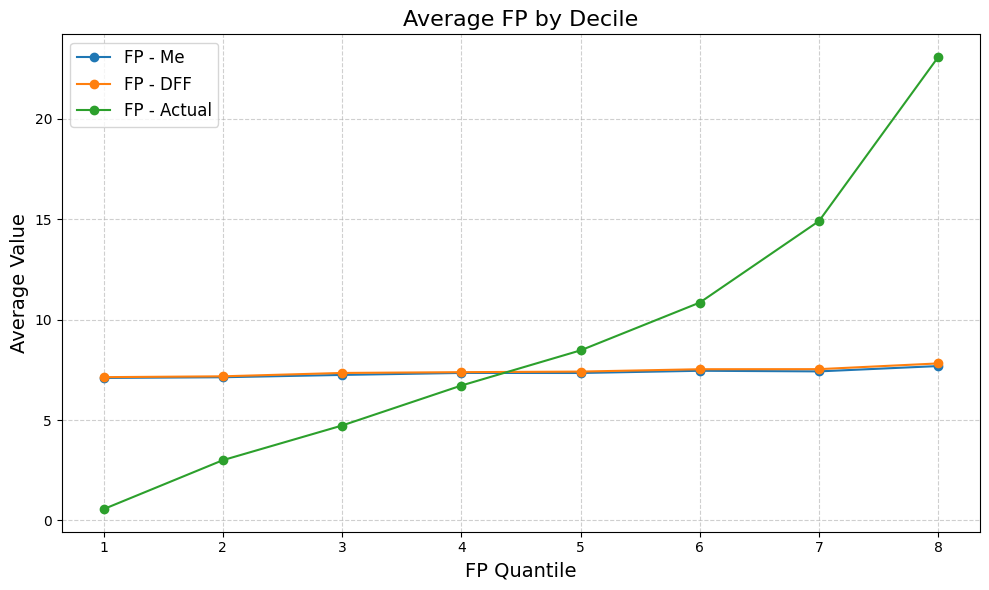

In [56]:
# Plot the averages
plt.figure(figsize=(10, 6))

# Plot FP averages
plt.plot(batters_quantile_averages['FP_quantile'], batters_quantile_averages['Avg_FP'], marker='o', label='FP - Me')

# Plot FP_DFF averages
plt.plot(batters_quantile_averages['FP_quantile'], batters_quantile_averages['Avg_FP_DFF'], marker='o', label='FP - DFF')

# Plot fp averages
plt.plot(batters_quantile_averages['FP_quantile'], batters_quantile_averages['Avg_fp'], marker='o', label='FP - Actual')

# Add titles and labels
plt.title('Average FP by Decile', fontsize=16)
plt.xlabel('FP Quantile', fontsize=14)
plt.ylabel('Average Value', fontsize=14)
plt.xticks(batters_quantile_averages['FP_quantile'])
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


##### Pitchers

Merge DFF projections onto my projections

In [57]:
pitchers_with_dff = pitchers_merged_df.drop_duplicates(['fullName', 'date']).merge(dff_df, on=['fullName', 'date'], how='inner')

Create error and success measures

In [58]:
pitchers_with_dff['error_me'] = (pitchers_with_dff['fp'] - pitchers_with_dff['FP'])
pitchers_with_dff['error_dff'] = (pitchers_with_dff['fp'] - pitchers_with_dff['FP_DFF'])

pitchers_with_dff['error_me2'] = pitchers_with_dff['error_me'] ** 2
pitchers_with_dff['error_dff2'] = pitchers_with_dff['error_dff'] ** 2

pitchers_with_dff['beat_dff'] = (pitchers_with_dff['error_me2'] < pitchers_with_dff['error_dff2']).astype('int')

##### Summary Statistics

In [59]:
pitcher_summary_stats = pd.DataFrame(pitchers_with_dff.dropna().query('starter == 1')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].mean())
pitcher_summary_stats.columns = ['Pitchers']
pitcher_summary_stats

,Pitchers
FP,14.048543
FP_DFF,13.842351
fp,13.864659
error_me,-0.183884
error_dff,0.022308
error_me2,109.287333
error_dff2,105.315334
beat_dff,0.472656


##### Quantiled

In [60]:
# Set number of quantiles
quantiles = 10

# Filter the dataframe
pitchers_filtered_df = pitchers_with_dff.query('FP > 4 and FP_DFF > 4')

# Create deciles based on FP
pitchers_filtered_df['FP_quantile'] = pd.qcut(pitchers_filtered_df['fp'], quantiles, labels=False) + 1

# Group by deciles and calculate averages for FP and FP_DFF
pitchers_quantile_averages = (pitchers_filtered_df.groupby('FP_quantile').agg(Avg_FP=('FP', 'mean'), Avg_FP_DFF=('FP_DFF', 'mean'), Avg_fp=('fp', 'mean')).reset_index())

print(pitchers_quantile_averages)


   FP_quantile     Avg_FP  Avg_FP_DFF     Avg_fp
0            1  12.601153   12.589996  -5.237033
1            2  13.053363   12.877156   2.462061
2            3  13.475084   13.002541   6.389231
3            4  13.330780   13.300104   9.590177
4            5  13.657874   13.521614  12.503384
5            6  13.896783   13.855967  15.673238
6            7  14.149798   14.213773  18.637307
7            8  14.986015   14.810410  21.826638
8            9  15.379141   15.333302  25.593943
9           10  16.204072   16.327485  32.582301


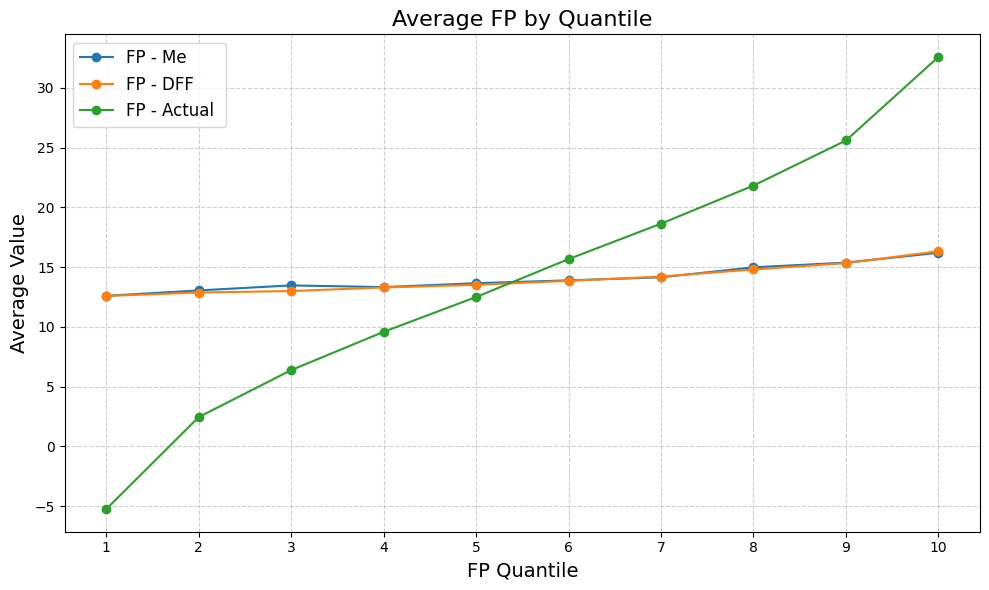

In [61]:
# Plot the averages
plt.figure(figsize=(10, 6))

# Plot FP averages
plt.plot(pitchers_quantile_averages['FP_quantile'], pitchers_quantile_averages['Avg_FP'], marker='o', label='FP - Me')

# Plot FP_DFF averages
plt.plot(pitchers_quantile_averages['FP_quantile'], pitchers_quantile_averages['Avg_FP_DFF'], marker='o', label='FP - DFF')

# Plot fp averages
plt.plot(pitchers_quantile_averages['FP_quantile'], pitchers_quantile_averages['Avg_fp'], marker='o', label='FP - Actual ')

# Add titles and labels
plt.title('Average FP by Quantile', fontsize=16)
plt.xlabel('FP Quantile', fontsize=14)
plt.ylabel('Average Value', fontsize=14)
plt.xticks(pitchers_quantile_averages['FP_quantile'])
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


Write to Excel

In [62]:
projection_evaluation_path = os.path.join(baseball_path, "C02. Players", "2. Competitor Projection Evaluations", f"{todaysdate} Competitor Projection Evaluation.xlsx")

Summary Statistics

In [63]:
summary_stats = pd.concat([batter_summary_stats, pitcher_summary_stats], axis=1)
summary_stats.to_excel(projection_evaluation_path, sheet_name='Summary Stats')

Quantiles

In [64]:
# Append the new DataFrame
with pd.ExcelWriter(projection_evaluation_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    batters_quantile_averages.to_excel(writer, sheet_name='BatterQuantiles', index=False)

In [65]:
# Append the new DataFrame
with pd.ExcelWriter(projection_evaluation_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pitchers_quantile_averages.to_excel(writer, sheet_name='PitcherQuantiles', index=False)